# Chart Understanding with Llava-NEXT and Structured Generation

In [1]:
import os
import json
import base64
import requests
from io import BytesIO

import numpy as np
import pandas as pd
import huggingface_hub
from PIL import Image, ImageOps
from PIL.Image import Image as PILImage
from transformers import LlavaNextProcessor
from transformers.image_processing_utils import select_best_resolution

/home/leloykun/anaconda3/envs/MMFM-Challenge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROMPT_FORMAT = "<system_prompt> USER: <image>\\n<user> ASSISTANT: "
SYSTEM_PROMPT_FORMAT = """You are a scientific chart explainer. You will receive an image with a chart in it as an input and you must answer the user's question based on the data from the chart. Be concise and don't yap. If you are uncertain, provide a range of possible answers. Output in the following json format: <json_format>."""

In [3]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-vicuna-13b-hf")
possible_resolutions = processor.image_processor.image_grid_pinpoints

In [4]:
# possible_resolutions += [
#     [672, 1008],
#     [1008, 672],
#     [1008, 1008],
# ]

In [5]:
def resize_and_pad_image(image: PILImage) -> PILImage:
    best_resolution = select_best_resolution(image.size, possible_resolutions)
    print(f"{best_resolution = }")
    resized_image = ImageOps.cover(image, best_resolution)
    resized_and_padded_image = ImageOps.pad(
        resized_image,
        best_resolution,
        method=processor.image_processor.resample,
        color=(255,255,255,0),
    )
    return resized_and_padded_image


def encode_local_image(image_path, resize_and_pad: bool=True):
    # load image
    image = Image.open(image_path)
    if resize_and_pad:
        image = resize_and_pad_image(image)
        print(f"New size: {image.size}")

    # Convert the image to a base64 string
    buffer = BytesIO()
    image.save(buffer, format="PNG")  # Use the appropriate format (e.g., JPEG, PNG)
    base64_image = base64.b64encode(buffer.getvalue()).decode('utf-8')

    # add string formatting required by the endpoint
    image_string = f"data:image/png;base64,{base64_image}"

    return image_string

In [6]:
def infer_chart_type(image_path: str) -> str:
    image_path_parts = image_path.split("/")
    print(f"{image_path_parts = }")
    if "_vbar_" in image_path_parts[-1]:
        return "Vertical Bar Chart"
    elif "_hbar_" in image_path_parts[-1]:
        return "Horizontal Bar Chart"
    elif "_line_" in image_path_parts[-1]:
        return "Line Chart"
    elif "_sct_" in image_path_parts[-1]:
        return "Scatter Plot"
    elif "_pie_" in image_path_parts[-1]:
        return "Pie Chart"
    else:
        return "Other Chart Type"

In [7]:
def build_tool():
    return {
        "type": "function",
        "function": {
            "name": "chart_information_extraction_tool",
            "description": "Extract information from a chart",
            "parameters": {
                "type": "object",
                "properties": {
                    "1_legends": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Groups of data having the same color in the chart. Can be found in the legend."
                    },
                    "2_axis_categories": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Categories in the chart. They are on the X-axis in vertical bar charts, line charts, and scatter plots. But they are on the Y-axis in horizontal bar charts.",
                    },
                    "3_reasoning": {"type": "string"},
                    "4_answer": {
                        "type": "string",
                        "description": "Concise answer to the user question."
                    },
                },
                "required": ["1_legends", "2_axis_categories", "3_reasoning", "4_answer"],
            },
        }
    }

In [8]:
API_URL = "https://bkliyhzstf7g5dyz.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [9]:
def run_inference(image_path, question, seed=0, max_length: int=100):
    image_base64 = encode_local_image(image_path)
    question_trimmed = question[len("<image>\n"):]
    chart_type = infer_chart_type(image_path)
    print(f"{chart_type = } | {question_trimmed = }")
    tool = build_tool()

    system_prompt = SYSTEM_PROMPT_FORMAT.replace(
        "<json_format>",
        json.dumps(tool["function"]["parameters"]["properties"]),
    )
    prompt = (
        PROMPT_FORMAT
        .replace("<system_prompt>", system_prompt)
        .replace("<image>", f"![]({image_base64})")
        .replace("<user>", f"This is a {chart_type}. {question_trimmed}")
    )
    print(f"{prompt = }")

    # This version of TGI uses an older version of Outlines
    # which re-orders the keys in the JSON in alphabetical order.
    # Hence the prefixes in the keys in the grammer
    response = query({
        "inputs": prompt,
        "parameters": {
            "return_full_text": False,
            "max_new_tokens": 2048,
            "frequency_penalty": 1,
            "temperature": 1,
            "top_p": 0.95,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "grammar": {
                "type": "json",
                "value": tool["function"]["parameters"],
            }
        }
    })
    print(f"{response = }")

    return json.loads(response[0]["generated_text"])["4_answer"]

In [10]:
image_path = "data/raw_datasets/mychart/images/328_hbar_0635a64e806fee03461eddecf061fd851a801f3b482d208e5c651e7c68c69585_66.png"

In [ ]:
image = Image.open(image_path)
image = resize_and_pad_image(image)
image

best_resolution = (672, 672)
New size: (672, 672)
image_path_parts = ['data', 'raw_datasets', 'mychart', 'images', '328_hbar_0635a64e806fee03461eddecf061fd851a801f3b482d208e5c651e7c68c69585_66.png']
chart_type = 'Horizontal Bar Chart' | question_trimmed = 'What is the accumulated amortization on completed technology?'
prompt = 'You are a scientific chart explainer. You will receive an image with a chart in it as an input and you must answer the user\'s question based on the data from the chart. Be concise and don\'t yap. If you are uncertain, provide a range of possible answers. Output in the following json format: {"1_legends": {"type": "array", "items": {"type": "string"}, "description": "Groups of data having the same color in the chart. Can be found in the legend."}, "2_axis_categories": {"type": "array", "items": {"type": "string"}, "description": "Categories in the chart. They are on the X-axis in vertical bar charts, line charts, and scatter plots. But they are on the Y-axis in 
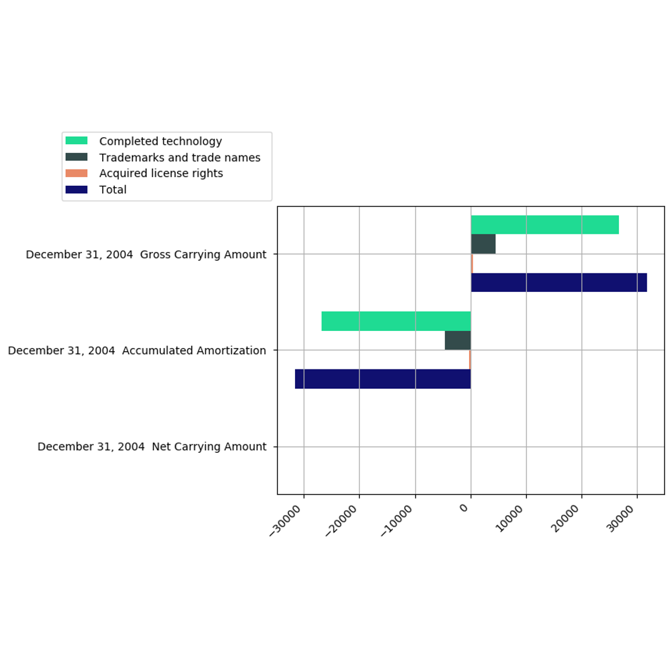

'Accumulated amortization on completed technology is shown as a blue horizontal bar in each of the charts for December 31, 2004, 2005, 2006, and 2007. The exact values for each year cannot be provided without looking at the actual chart numbers.'

In [12]:
run_inference(
    image_path,
    "<image>\nWhat is the accumulated amortization on completed technology?",
)

In [13]:
dataset_name = "mychart"
dataset_path = os.path.join("data/raw_datasets", dataset_name, "annot_wo_answer.json")
print(dataset_path)
assert os.path.exists(dataset_path)

df_data = pd.read_json(dataset_path)

data/raw_datasets/mychart/annot_wo_answer.json


In [14]:
!mkdir -p inference_results/llava-1-6-vicuna-13b-hf

In [ ]:
failed_idx = set(failed_idx)
failed_idx

In [ ]:
failed_idx = set()
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"

    image_path = f"data/raw_datasets/{dataset_name}/images/{row['image']}"
    question = row["conversations"][0]["value"]

    if os.path.exists(answer_txt_path):
        continue
    print(id, idx, question)

    try:
        answer = run_inference(image_path, question)
        print(f"{answer = }")
        with open(answer_txt_path, "w") as f:
            f.write(str(answer))
    except Exception as e:
        print(">>>>>>> ERROR", idx, row, e, "<<<<<<<")
        failed_idx.add(idx)
    print("---------")

In [ ]:
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if not os.path.exists(answer_txt_path):
        failed_idx.add(idx)
        continue

    with open(answer_txt_path, "r") as f:
        answer = f.read()

    if len(answer) >= 50:
        failed_idx.add(idx)

In [ ]:
failed_idx

In [ ]:
df_data.iloc[list(failed_idx)]

In [ ]:
failed_idx_2 = set()
for idx, row in df_data.iloc[list(failed_idx)].iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/llava-1-6-vicuna-13b-hf/{id}.txt"
    if os.path.exists(answer_txt_path):
        os.remove(answer_txt_path)
    print(id, idx)

    image_path = f"data/raw_datasets/{dataset_name}/images/{row['image']}"
    question = row["conversations"][0]["value"]

    try:
        answer = run_inference(image_path, question, seed=42)
        with open(answer_txt_path, "w") as f:
            f.write(answer)
    except Exception as e:
        print(idx, row, e)
        failed_idx_2.add(idx)

In [ ]:
failed_idx_2

In [ ]:
df_data.iloc[220]["image"]

In [ ]:
df_data.iloc[220]["conversations"]